## Validation demo

authors: Tuguldur Sukhbold

Our training set has 366 fields, where 300 are used in training and the rest for validation. In this notebook we perform validations on the last 66 fields using trained weights.

First we load the trained weights:

In [1]:
datapath = '../../d/'
PATH2weight = '../../weights/circle_ep15_small.pth'

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def getInstanceSegmentationModel(num_classes):
    """
    the exact instance segmentation model used for training
    note: do not change anything here, or else weights will not properly load
    """

    # pre-trained model on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def loadTrainedModel(PATH2weights):
    """
    load the weight from given path
    """

    num_classes = 2
    model = getInstanceSegmentationModel(num_classes)
    model.load_state_dict(torch.load(PATH2weights, map_location=device))

    return model


print(device)

cpu


In [2]:
def getPlanet(fieldID):
    j17 = plt.imread(f'{datapath}planet-jun17/{fieldID}.png')
    j18 = plt.imread(f'{datapath}planet-jun18/{fieldID}.png')
    d17 = plt.imread(f'{datapath}planet-dec17/{fieldID}.png')
    d18 = plt.imread(f'{datapath}planet-dec18/{fieldID}.png')
    return j17, j18, d17, d18

def getHighContrast(j17, j18, d17, d18):
    summer = j17 + j18
    summer = summer / np.amax(summer)
    winter = d17 + d18
    winter = winter / np.amax(winter)
    diff = winter * summer
    return diff


In [3]:
def getGrayNNmask(model):
    """
    evaluation based on loaded weight
    """

    # convert image to tensor
    img   = Image.open('tmp.png').convert("RGB")
    imgT  = F.to_tensor(img)

    # evaluate
    model.eval()
    with torch.no_grad(): prediction = model([imgT.to(device)])

    # convert result back to gray image
    img = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())
    img = img.convert('L')

    return np.array(img)


def makeEnhancedImage(fieldID):
    j17, j18, d17, d18 = getPlanet(fieldID)
    img = getHighContrast(j17, j18, d17, d18)
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    img.save('tmp.png')


In [4]:
def getDisplacement1(mask):
    """
    based on dist to mask center
    """
    
    # just avg point for center for simple shapes
    xindx = np.where(mask > 0)[-1]
    yindx = np.where(mask > 0)[0]
    xmin, xmax = min(xindx), max(xindx)
    ymin, ymax = min(yindx), max(yindx)
    x1 = xmin + (xmax - xmin) / 2.
    y1 = ymin + (ymax - ymin) / 2.
        
    # displacement
    cX = 10.986328125 / 2
    cY = 10.985731758 / 2
    x0, y0 = mask.shape[1]//2, mask.shape[0]//2
    x = (x0-np.round(x1)) / mask.shape[1] *cX
    y = (y1-np.round(y0)) / mask.shape[0] *cY
    
    return x, y

def getDisplacement2(mask):
    """
    based on dist to closest vertex of bbox
    """
    
    # image center
    x0, y0 = mask.shape[1]//2, mask.shape[0]//2

    # bbox vertices
    xindx = np.where(mask > 0)[-1]
    yindx = np.where(mask > 0)[0]
    xmin, xmax = min(xindx), max(xindx)
    ymin, ymax = min(yindx), max(yindx)

    # vertex with min distance
    xs = np.array([xmin, xmin, xmax, xmax])
    ys = np.array([ymax, ymin, ymin, ymax])
    ds = np.sqrt((xs-x0)**2 + (ys-y0)**2)
    imin = np.where(ds == min(ds))[0][0]
    x1, y1 = xs[imin], ys[imin]
        
    # displacement
    cX = 10.986328125 / 2
    cY = 10.985731758 / 2
    x = (x0-np.round(x1)) / mask.shape[1] *cX
    y = (y1-np.round(y0)) / mask.shape[0] *cY
    
    return x, y

In [5]:
model = loadTrainedModel(PATH2weight)
train = pd.read_csv(f'{datapath}train-unique.csv')

xPred, yPred = [], []
xChk,  yChk  = [], []
for index, row in train.iterrows():
    if index > 299:
        fieldID = row.ID.split('_')[-1]
        makeEnhancedImage(fieldID)
        mask = getGrayNNmask(model)
        x, y = getDisplacement2(mask)
        xPred.append(x)
        yPred.append(y)
        xChk.append(row['x'])
        yChk.append(row['y'])
        print(index)

xPred = np.array(xPred)
yPred = np.array(yPred)
xChk  = np.array(xChk)
yChk  = np.array(yChk)

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365


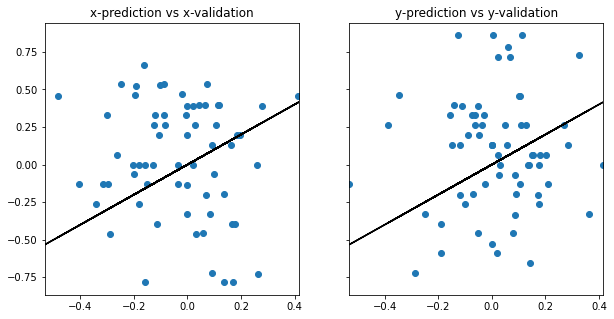

In [23]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10,5))
ax[0].scatter(xChk, xPred)
ax[0].set_title('x-prediction vs x-validation')
ax[0].set_xlim(min(xChk), max(xChk))
ax[0].plot(xChk, xChk, c='black')

ax[1].scatter(yChk, yPred)
ax[1].set_title('y-prediction vs y-validation')
ax[1].set_xlim(min(yChk), max(yChk))
ax[1].plot(yChk, yChk, c='black')
plt.show()

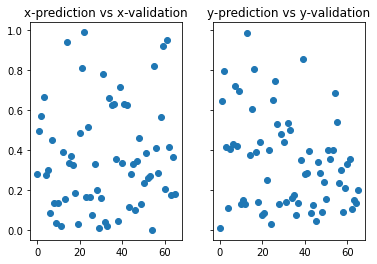

In [7]:
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(np.arange(len(xChk)), abs(xChk - xPred))
ax[0].set_title('x-prediction vs x-validation')
ax[1].scatter(np.arange(len(xChk)), abs(yChk - yPred))
ax[1].set_title('y-prediction vs y-validation')
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error

tst = np.column_stack((xChk, yChk))
pred = np.column_stack((xPred, yPred))

mean_absolute_error(tst, pred)

0.3502145379427588